# Analysis of the abv of the beers

We will now try to find out if there is a correlation between the abv of the beers and the different sort of climates to see if it might explain the differences in the appreciation of the beers.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
# from spacy_language_detection import LanguageDetector
from scipy.stats import chi2_contingency
from scipy import stats

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [29]:
us_users_ratings = pd.read_csv("../data/us_users_ratings.csv", compression="gzip")

/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_45844/2338260825.py:1: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  us_users_ratings = pd.read_csv("../data/us_users_ratings.csv", compression="gzip")


In [30]:
# For the analysis, drop NaN from the columns of interest
us_users_ratings = us_users_ratings.dropna(subset=["overall", "abv"])

## Plot on a US map 
The following code allows us to plot any numerical variable on a US map. We will use it to plot the abv of the beers.

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import geopandas as gpd
import pandas as pd


def plot_climate_one_stat(
    df, column, title, column_ticks=None, cmap_name="YlOrRd"
):  # RdBu_r
    """
    This function plots on a map of the United States the mean of the column passed as an argument for each state depending on its climate.
    df should have a column "climate" and a column str(column) with the values to plot. Requires to call plt.show() after the function call.

    Args:
        df (pd.DataFrame): DataFrame containing the data to plot
        column (str): Column to plot
        title (str): Title of the plot
        column_ticks (list, optional): List of strings to use as ticks on the colorbar. Defaults to None.
        cmap_name (str, optional): Name of the colormap to use. Defaults to "YlOrRd".
    """

    us_map = gpd.read_file("../data/Maps/US/cb_2018_us_state_500k.shp")
    states_climate = pd.read_csv("../data/states_climate.csv")

    # Add climate column to us_map and the df
    us_map = us_map.merge(states_climate, left_on="NAME", right_on="State")
    us_map = us_map.merge(df, left_on="Climate", right_on="climate")

    # For display purposes, move Alaska and Hawaii to the East
    alaska = us_map[us_map["NAME"] == "Alaska"].geometry
    hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

    alaska = alaska.translate(xoff=40)
    hawaii = hawaii.translate(xoff=40)

    us_map_shifted = us_map.copy()
    us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
    us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii

    fig, ax = plt.subplots(figsize=(8, 7))
    us_map_shifted.boundary.plot(ax=ax, linewidth=1, color="black")

    # Plot on the colorbar only the unique values associated to the each climate type
    values = df[column].unique()
    # Sort the dictionary by descending values
    norm = Normalize(vmin=values.min(), vmax=values.max())
    sm = cm.ScalarMappable(cmap=cmap_name, norm=norm)
    sm.set_array([])

    us_map_shifted.plot(
        column=column,
        cmap=cmap_name,
        ax=ax,
        legend=False,
        missing_kwds={"color": "lightgrey", "label": "Missing values"},
    )

    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", ticks=values)
    cbar.set_ticks(values)

    ticks_labels_dict = zip(values, df[column_ticks].unique())

    cbar.set_ticklabels(
        [label + ": {:.2f}".format(value) for value, label in ticks_labels_dict]
    )
    ax.set_title(title)
    # change the size of the title
    ax.title.set_size(13)
    ax.set_axis_off()
    ax.set_xlim(-140, -60)

    plt.show()
    
def plot_climate_multiple_stats(
    df,
    columns,
    titles,
    column_ticks=None,
    cmap_name="YlOrRd",
    figsize=(8, 7),
    separate_colorbars=False,
):
    """
    This function plots on a map of the United States the mean of the column passed as an argument for each state depending on its climate.
    df should have a column "climate" and a column str(column) with the values to plot. Requires to call plt.show() after the function call.

    Args:
        df (pd.DataFrame): DataFrame containing the data to plot
        column (str): Column to plot
        title (str): Title of the plot
        column_ticks (str, optional): Column to use for the ticks of the colorbar. If None, the column passed as argument is used.
        cmap_name (str, optional): Name of the colormap to use. Defaults to "YlOrRd".
        figsize (tuple, optional): Size of the figure. Defaults to (8, 7). It is to be noted that if mutiple plots are displayed, the figsize is multiplied by the number of plots along the x-axis.
        separate_colorbars (bool, optional): If True, each plot has its own colorbar. If False, all the plots share the same colorbar. Defaults to False.
    """

    us_map = gpd.read_file("../data/Maps/US/cb_2018_us_state_500k.shp")
    states_climate = pd.read_csv("../data/states_climate.csv")

    # Add climate column to us_map and the df
    us_map = us_map.merge(states_climate, left_on="NAME", right_on="State")
    us_map = us_map.merge(df, left_on="Climate", right_on="climate")

    # For display purposes, move Alaska and Hawaii to the East
    alaska = us_map[us_map["NAME"] == "Alaska"].geometry
    hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

    alaska = alaska.translate(xoff=40)
    hawaii = hawaii.translate(xoff=40)

    us_map_shifted = us_map.copy()
    us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
    us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii

    num_plots = len(columns)
    figsize = (figsize[0] * num_plots, figsize[1])
    fig, axes = plt.subplots(1, num_plots, figsize=figsize)
    
    if not separate_colorbars:
        # Get the min and max values of the columns to plot
        vmin = df[columns].min().min()
        vmax = df[columns].max().max()
    
    
    for i in range(num_plots):
        
        us_map_shifted.boundary.plot(ax=axes[i], linewidth=1, color="black")
        
        # Plot on the colorbar only the unique values associated to the each climate type
        values = df[columns[i]].unique()
        
        if separate_colorbars:
            vmin = values.min()
            vmax = values.max()
        
        # Sort the dictionary by descending values
        norm = Normalize(vmin=vmin, vmax=vmax)
        sm = cm.ScalarMappable(cmap=cmap_name, norm=norm)
        sm.set_array([])
        
        us_map_shifted.plot(
            column=columns[i],
            cmap=cmap_name,
            ax=axes[i],
            legend=False,
            missing_kwds={"color": "lightgrey", "label": "Missing values"},
            vmin=vmin,
            vmax=vmax
        )
        
        cbar = fig.colorbar(sm, ax=axes[i], orientation="vertical", ticks=values)
        cbar.set_ticks(values)
        cbar.set_ticklabels(
            [label + ": {:.2f}".format(value) for value, label in zip(values, df[column_ticks[i]].unique())]
        )
        
        axes[i].set_title(titles[i])
        # change the size of the title
        axes[i].title.set_size(13)
        
        axes[i].set_axis_off()
        axes[i].set_xlim(-140, -60)
        
    plt.tight_layout()
    plt.show()
        


In a first time, let us take a look at abv distribution in our dataset.

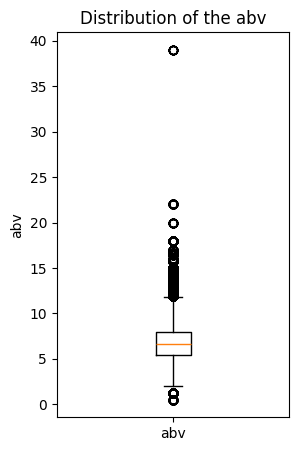

In [32]:
# boxplot of abv of the us
fig, ax = plt.subplots(figsize=(3, 5))
ax.boxplot(us_users_ratings["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()

It appears that there are various outliers with very high value. These risk to bias our means and analysis so we start by removing them. To do so, we compute the 5th and 95th quantile of the abv and remove all the values that are not in this range.

5th percentile: 4.5
95th percentile: 11.0
Shape before filtering: (862743, 36)
Shape after filtering: (783427, 36)
Mean of the abv: 6.87


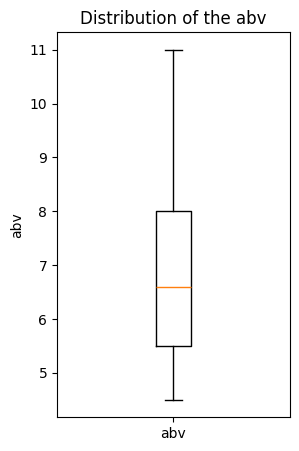

In [33]:
# keep only the beers which have an abv between 0 and 95% (to remove outliers)
quantile_5 = us_users_ratings["abv"].quantile(0.05)
quantile_95 = us_users_ratings["abv"].quantile(0.95)

print("5th percentile:", quantile_5)
print("95th percentile:", quantile_95)

print("Shape before filtering:", us_users_ratings.shape)
us_abv_ratings = us_users_ratings[
    (us_users_ratings["abv"] >= quantile_5) & (us_users_ratings["abv"] <= quantile_95)
]
print("Shape after filtering:", us_abv_ratings.shape)

print("Mean of the abv: {:.2f}".format(us_abv_ratings["abv"].mean()))

# Boxplot of the abv of us_abv_ratings
fig, ax = plt.subplots(figsize=(3, 5))
ax.boxplot(us_abv_ratings["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()

Now, the data looks more reasonable. We can see that the abv is mostly between 4.5% and 11% with a mean of 6.87%.

We can start by aggregating by climate and see if there is a difference in the abv of the beers.

In [34]:
# sort a dataframe with the name ot the climate
climate_names = pd.DataFrame(us_abv_ratings["climate"].unique(), columns=["climate"])

# to store the climate dataframes
climate_dataframes = {}

# create a for loop to create separate dataframes for each climate based on the climate_names
for climate in climate_names["climate"]:
    climate_df = pd.DataFrame(
        us_abv_ratings[us_abv_ratings["climate"] == climate].reset_index(drop=True)
    )
    climate_dataframes[climate] = climate_df.sort_values(
        by="overall", ascending=False
    ).reset_index(drop=True)

We will look at the abv of each climate in three different manners:
- The mean abv of the beers in each climate after weighting them by the `overall` appreciation of the beers
- The mean abv of the beers in each climate after keeping only the 3 best beers in each climate
- The mean abv of the beers in each climate after keeping only the 3 most reviewed beers in each climate

The goal of this is to see if the abv of the beers is correlated with the appreciation of the beers by climate.

In the following cells, we create a new dataset `us_abv_means` that will contain these scores at the end.

In [35]:
# Create the dataset
us_abv_means = pd.DataFrame(
    columns=["climate", "mean_abv_weighted", "mean_abv_best", "mean_abv_most"]
)
    
# Compute the mean abv for each climate weighted by overall score
for climate in climate_names["climate"]:
    climate_df = us_abv_ratings[us_abv_ratings["climate"] == climate]

    # Compute the mean abv for each climate weighted by overall score

    mean_abv_weighted = (climate_df["abv"] * climate_df["overall"]).sum() / climate_df[
        "overall"
    ].sum()

    us_abv_means.loc[len(us_abv_means)] = [climate, mean_abv_weighted, 0.0, 0.0]
    
    
# Find most liked beers for each climate
keeping_best_beers = {}

# create new dataframes containign the best three beers for each climate
for climate, climate_df in climate_dataframes.items():
    us_grouped_beers = climate_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    keeping_best_beers[climate] = climate_df[
        climate_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)
for climate in keeping_best_beers:
    # calculate the mean of the abv in the column abv of the dataframe
    mean_abv_best = keeping_best_beers[climate]["abv"].mean()
    us_abv_means.loc[
        us_abv_means["climate"] == climate, "mean_abv_best"
    ] = mean_abv_best
    
    
# Find most reviewed beers for each climate
keeping_most_reviewed_beers = {}

for climate, climate_df in climate_dataframes.items():
    # get number of occurences of each style of beer
    num_reviews = climate_df["general_style"].value_counts()

    # keep only the 3 most reviewed beers
    most_reviewed = num_reviews[:3]

    keeping_most_reviewed_beers[climate] = climate_df[
        climate_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)
for climate in keeping_most_reviewed_beers:
    # calculate the mean of the abv in the column abv of the dataframe
    mean_abv_most = keeping_most_reviewed_beers[climate]["abv"].mean()
    us_abv_means.loc[
        us_abv_means["climate"] == climate, "mean_abv_most"
    ] = mean_abv_most


display(us_abv_means)

,climate,mean_abv_weighted,mean_abv_best,mean_abv_most
0,Cfa,6.910911,7.356880,6.836905
1,Dfa,6.965748,7.459210,6.903023
2,Cfb,6.758007,7.322380,6.774415
3,Dfb,6.896353,7.336444,6.819313
4,Dfc,6.867785,7.230568,6.766260
5,Dsc,6.795549,7.220047,6.700405
6,Dsb,6.870914,7.244643,6.776383
7,Csa,6.990549,7.300237,6.944616
8,Csb,6.855522,7.170656,6.780525
9,Bsk,6.849988,7.268724,6.807197


Looking at these results numerically make it appear as if there was a slight difference between the climates. However, the difference is not very large, furthermore it is hard to interpret the results without a visual representation.

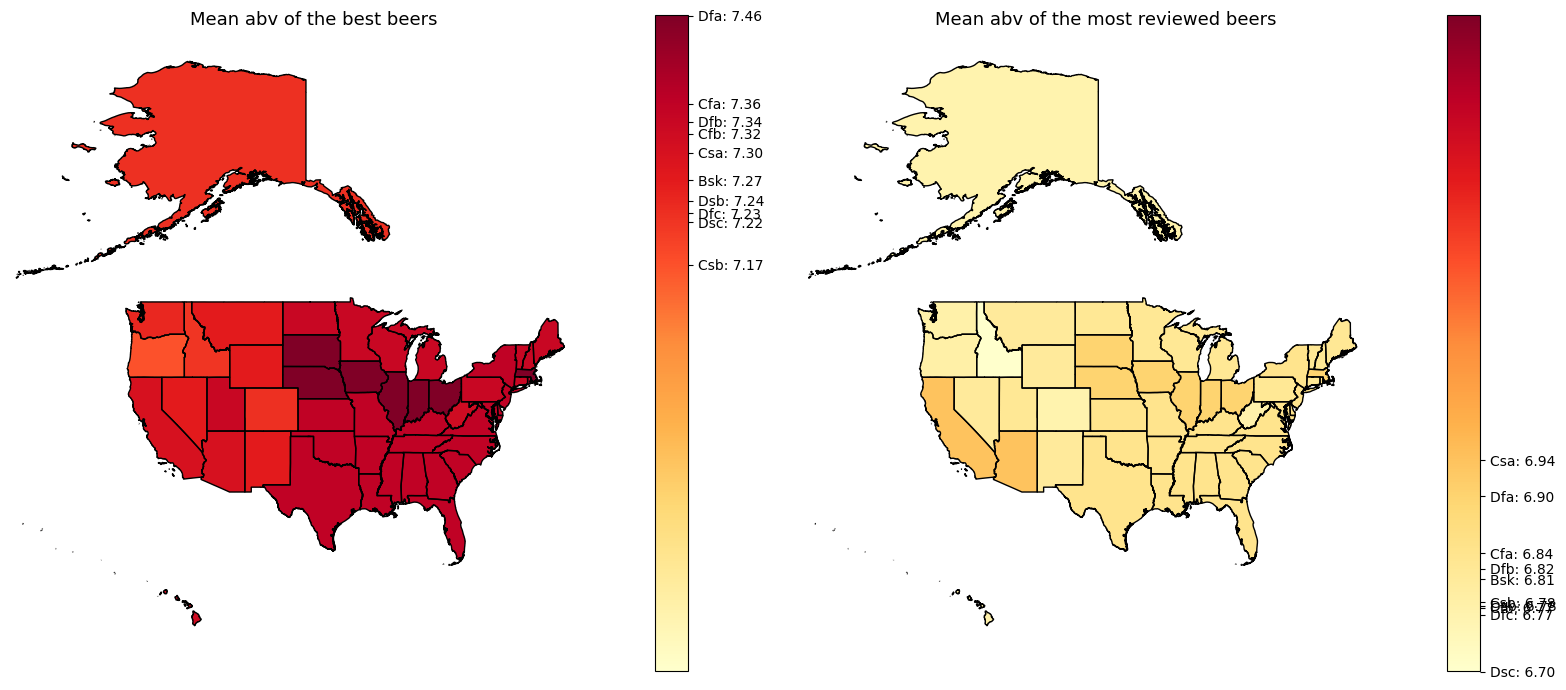

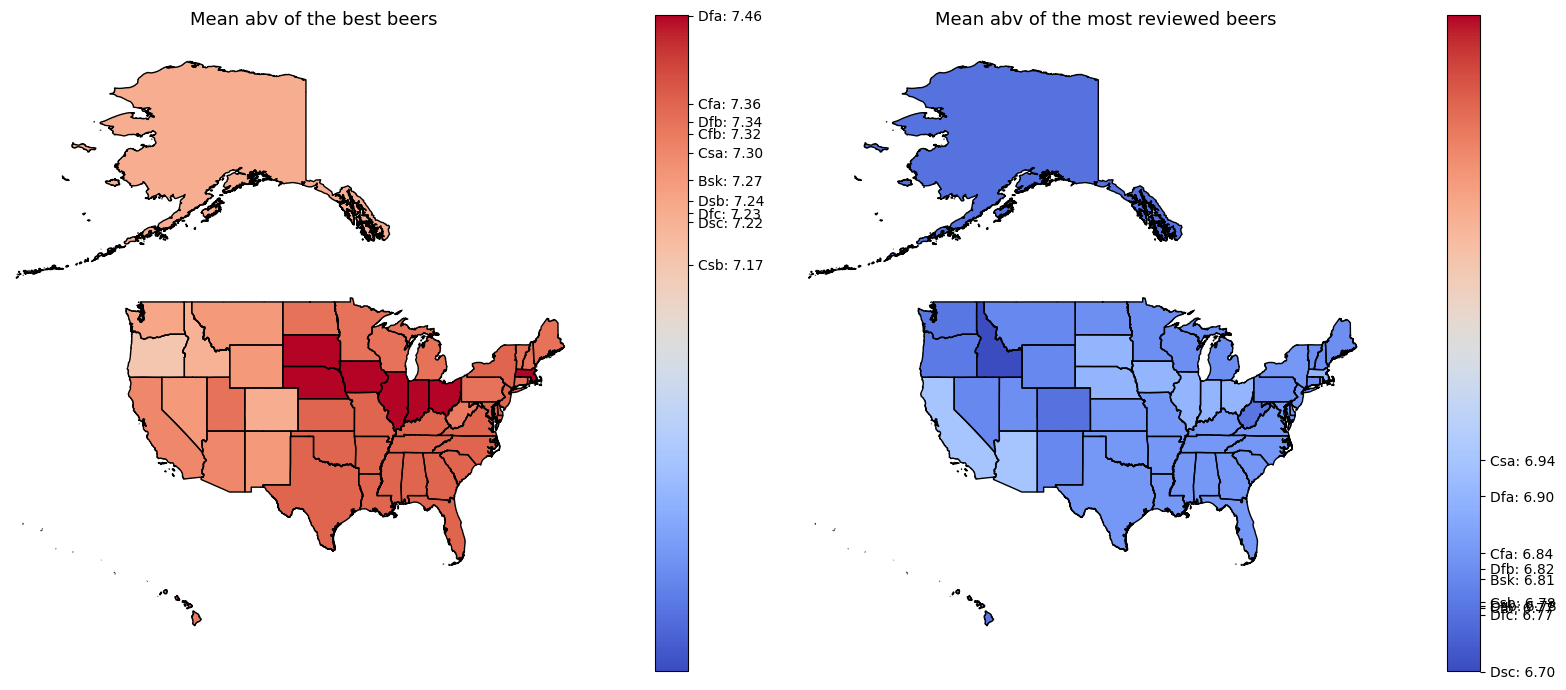

In [36]:
plot_climate_multiple_stats(us_abv_means, columns=["mean_abv_best", "mean_abv_most"], titles=["Mean abv of the best beers", "Mean abv of the most reviewed beers"], column_ticks=["climate", "climate"], cmap_name="YlOrRd")
plot_climate_multiple_stats(us_abv_means, columns=["mean_abv_best", "mean_abv_most"], titles=["Mean abv of the best beers", "Mean abv of the most reviewed beers"], column_ticks=["climate", "climate"], cmap_name="coolwarm")

We also check the statistical significance of the difference between the climates by performing a one-way ANOVA test. The null hypothesis is that the means of the abv of the beers in each climate are equal.

In [37]:
# One-way ANOVA test for the mean abv of each climate
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate == zone]["abv"]
        for zone in us_abv_ratings.climate.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate
res = stats.f_oneway(
    *[keeping_best_beers[zone]["abv"] for zone in keeping_best_beers.keys()], axis=0
)
print("One-way ANOVA test for the mean abv of best beers of each climate:", res[1])

# One-way ANOVA test for the mean abv of most reviewed beers of each climate
res = stats.f_oneway(
    *[
        keeping_most_reviewed_beers[zone]["abv"]
        for zone in keeping_most_reviewed_beers.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of most reviewed beers of each climate:",
    res[1],
)

One-way ANOVA test for the mean abv of each climate: 5.168135814480176e-101
One-way ANOVA test for the mean abv of best beers of each climate: 3.247824368429714e-121
One-way ANOVA test for the mean abv of most reviewed beers of each climate: 1.7894967358885408e-114


They are indeed below the threshold of 0.05, which means that we can reject the null hypothesis and say that the means are different.

## Analysis of the subcategories of the climates

As before, we will now look at the abv of the beers in each subcategory of the climates. We will start with the schemes that we used before:

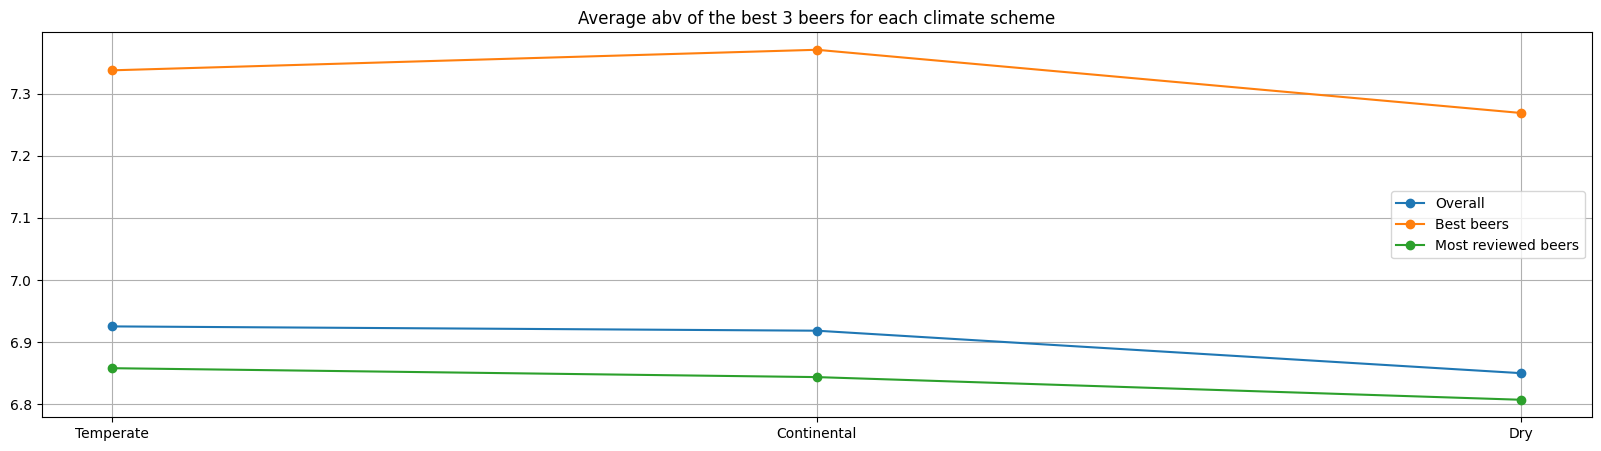

In [38]:
# Now test the climate scheme
mean_abv_weighted = {}
best_beers_scheme_dfs = {}
best_beers_scheme_abv = {}
most_reviewed_scheme_dfs = {}
most_reviewed_scheme_abv = {}

for climate_s in us_users_ratings["climate_scheme"].unique():
    climate_scheme_df = us_abv_ratings[us_abv_ratings["climate_scheme"] == climate_s]

    mean_abv_weighted[climate_s] = (
        climate_scheme_df["abv"] * climate_scheme_df["overall"]
    ).sum() / climate_scheme_df["overall"].sum()

    us_grouped_beers = climate_scheme_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    # keep only the 3 most reviewed beers
    num_reviews = climate_scheme_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]

    best_beers_scheme_dfs[climate_s] = climate_scheme_df[
        climate_scheme_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)
    best_beers_scheme_abv[climate_s] = best_beers_scheme_dfs[climate_s]["abv"].mean()

    most_reviewed_scheme_dfs[climate_s] = climate_scheme_df[
        climate_scheme_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)
    most_reviewed_scheme_abv[climate_s] = most_reviewed_scheme_dfs[climate_s][
        "abv"
    ].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(
    [
        mean_abv_weighted[climate_s]
        for climate_s in us_users_ratings["climate_scheme"].unique()
    ],
    "o-",
    label="Overall",
)
ax.plot(
    [
        best_beers_scheme_abv[climate_s]
        for climate_s in us_users_ratings["climate_scheme"].unique()
    ],
    "o-",
    label="Best beers",
)
ax.plot(
    [
        most_reviewed_scheme_abv[climate_s]
        for climate_s in us_users_ratings["climate_scheme"].unique()
    ],
    "o-",
    label="Most reviewed beers",
)
ax.set_xticks(
    range(len(us_users_ratings["climate_scheme"].unique())),
    us_users_ratings["climate_scheme"].unique(),
)
ax.set_title("Average abv of the best 3 beers for each climate scheme")
ax.grid()
ax.legend()
plt.show()

It appears that they are indeed some variations between the subcategories of the climates. Let's plot them on a map to see if we can see some patterns.

,climate,climate_scheme,abv_mean,abv_mean_most_reviewd,abv_mean_overall
0,Cfa,Temperate,7.337447,6.858030,6.925281
1,Dfa,Continental,7.370499,6.843697,6.918382
2,Cfb,Temperate,7.337447,6.858030,6.925281
3,Dfb,Continental,7.370499,6.843697,6.918382
4,Dfc,Continental,7.370499,6.843697,6.918382
5,Dsc,Continental,7.370499,6.843697,6.918382
6,Dsb,Continental,7.370499,6.843697,6.918382
7,Csa,Temperate,7.337447,6.858030,6.925281
8,Csb,Temperate,7.337447,6.858030,6.925281
9,Bsk,Dry,7.268724,6.807197,6.849988


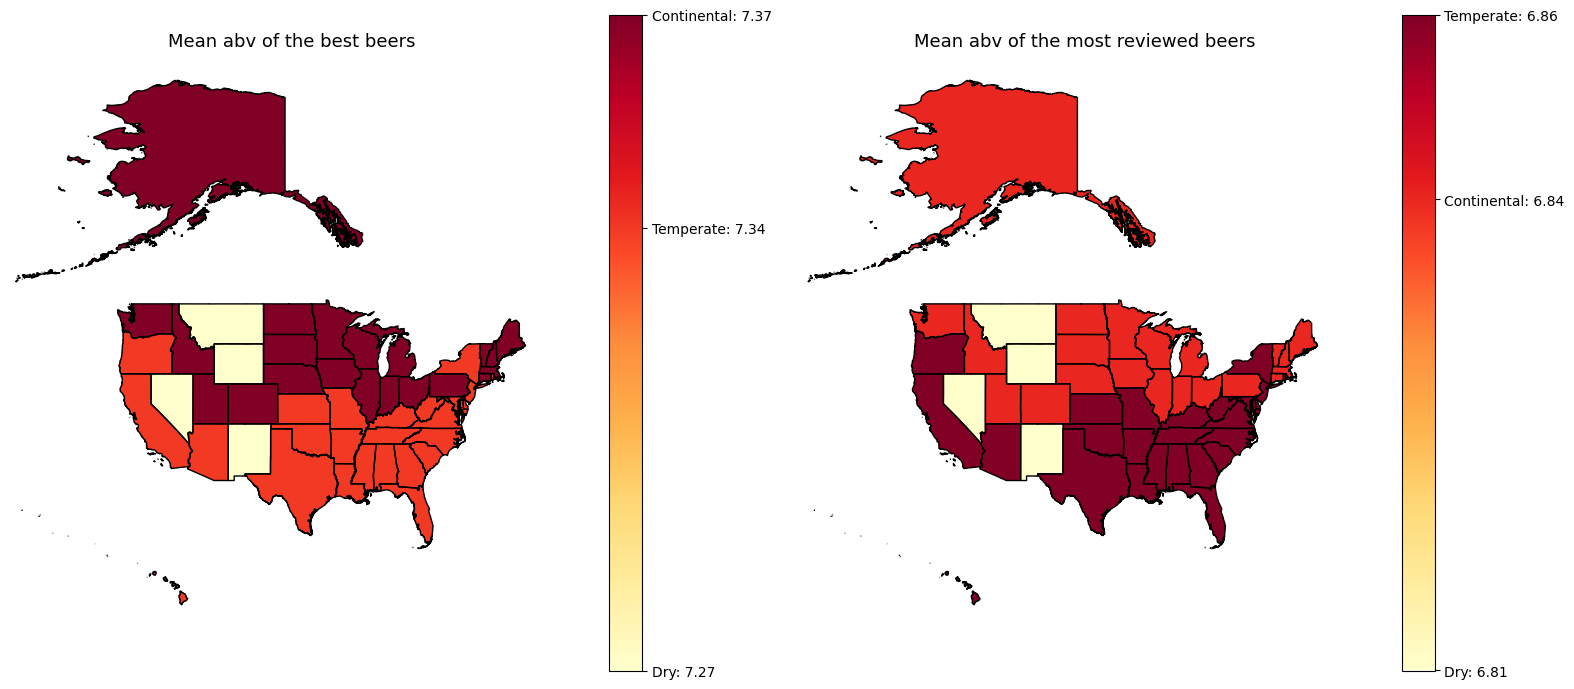

In [41]:
# load the df with the climate classified
climate_classified = pd.read_csv("../data/climate_classified.csv")

# create a df with all the climate in a column,
# in the second the corresponding climate scheme a
climate_names = pd.DataFrame(us_abv_ratings["climate"].unique(), columns=["climate"])
climate_names["climate_scheme"] = climate_names["climate"].map(
    climate_classified.set_index("climate")["scheme"]
)
# in the third the average abv of the best 3 beers for each climate scheme
climate_names["abv_mean"] = climate_names["climate_scheme"].map(best_beers_scheme_abv)

# in the fourth the average abv of the most reviewed beers for each climate scheme
climate_names["abv_mean_most_reviewd"] = climate_names["climate_scheme"].map(
    most_reviewed_scheme_abv
)

# in the fifth the average abv of all the beers for each climate scheme
climate_names["abv_mean_overall"] = climate_names["climate_scheme"].map(
    mean_abv_weighted
)

display(climate_names)

plot_climate_multiple_stats(
    climate_names,
    columns=["abv_mean", "abv_mean_most_reviewd"],
    titles=[
        "Mean abv of the best beers",
        "Mean abv of the most reviewed beers",
    ],
    column_ticks=["climate_scheme", "climate_scheme"],
    cmap_name="YlOrRd",
    separate_colorbars=True,
)

In [42]:
# One-way ANOVA test for the mean abv of each climate scheme
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_scheme == zone]["abv"]
        for zone in us_abv_ratings.climate_scheme.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate scheme:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate scheme
res = stats.f_oneway(
    *[best_beers_scheme_dfs[zone]["abv"] for zone in best_beers_scheme_dfs.keys()],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate scheme:", res[1]
)

# One-way ANOVA test for the mean abv of most reviewed beers of each climate scheme
res = stats.f_oneway(
    *[
        most_reviewed_scheme_dfs[zone]["abv"]
        for zone in most_reviewed_scheme_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate scheme:", res[1]
)

One-way ANOVA test for the mean abv of each climate scheme: 1.4982658694334239e-06
One-way ANOVA test for the mean abv of best beers of each climate scheme: 2.1477906266220373e-11
One-way ANOVA test for the mean abv of best beers of each climate scheme: 0.00031254912410991274


The previous one-way ANOVA test show that these variations are statistically significant.

We can now look at the climate precipitation and abv.

Overall average of best beers for climate without dry season: 3.981228746091151
Overall average of most reviewed beers for climate without dry season: 3.8670259238566245
Overall average of best beers for climate with dry season: 3.9844210078923337
Overall average of most reviewed beers for climate with dry season: 3.87191618588856


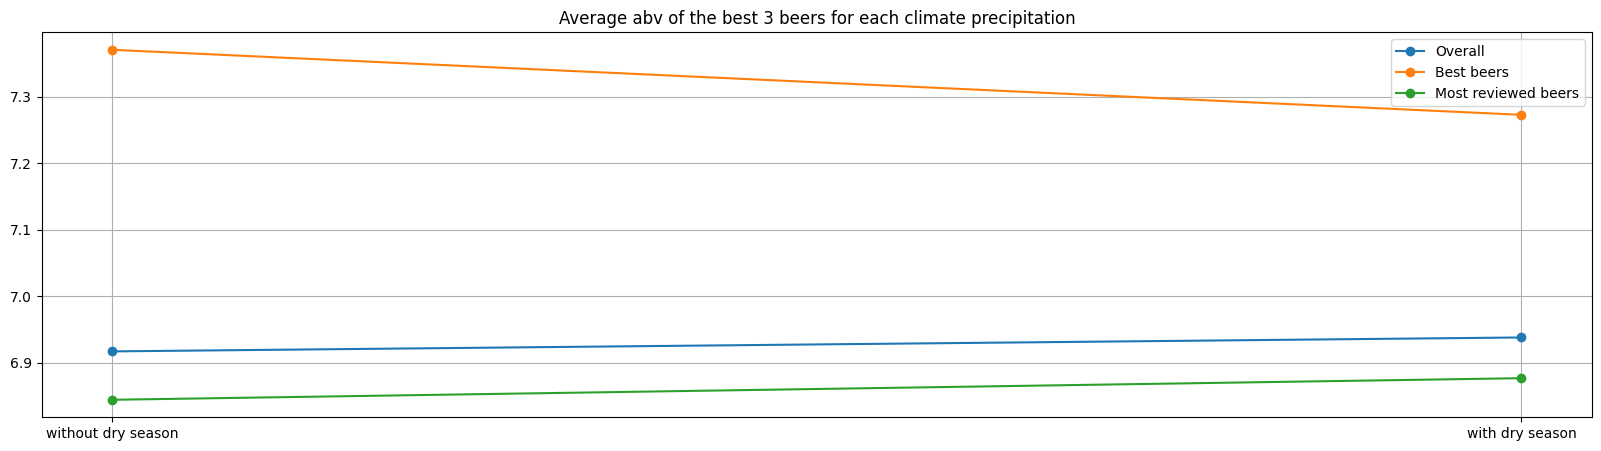

In [43]:
# Now test the climate precipitation, as there are multiple values, let's check their abv differences globally first
mean_abv_weighted = {}
best_beers_precipitation_dfs = {}
best_beers_precipitation_abv = {}
most_reviewed_precipitation_dfs = {}
most_reviewed_precipitation_abv = {}

for climate_p in us_users_ratings["climate_precipitation"].unique():
    climate_precipitation_df = us_abv_ratings[
        us_abv_ratings["climate_precipitation"] == climate_p
    ]

    mean_abv_weighted[climate_p] = (
        climate_precipitation_df["abv"] * climate_precipitation_df["overall"]
    ).sum() / climate_precipitation_df["overall"].sum()

    us_grouped_beers = climate_precipitation_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    # keep only the 3 most reviewed beers
    num_reviews = climate_precipitation_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]

    best_beers_precipitation_dfs[climate_p] = climate_precipitation_df[
        climate_precipitation_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)

    print(
        "Overall average of best beers for climate {}: {}".format(
            climate_p, best_beers_precipitation_dfs[climate_p]["overall"].mean()
        )
    )

    best_beers_precipitation_abv[climate_p] = best_beers_precipitation_dfs[climate_p][
        "abv"
    ].mean()

    most_reviewed_precipitation_dfs[climate_p] = climate_precipitation_df[
        climate_precipitation_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)

    print(
        "Overall average of most reviewed beers for climate {}: {}".format(
            climate_p, most_reviewed_precipitation_dfs[climate_p]["overall"].mean()
        )
    )

    most_reviewed_precipitation_abv[climate_p] = most_reviewed_precipitation_dfs[
        climate_p
    ]["abv"].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(
    [
        mean_abv_weighted[climate_p]
        for climate_p in us_users_ratings["climate_precipitation"].unique()
    ],
    "o-",
    label="Overall",
)
ax.plot(
    [
        best_beers_precipitation_abv[climate_p]
        for climate_p in us_users_ratings["climate_precipitation"].unique()
    ],
    "o-",
    label="Best beers",
)
ax.plot(
    [
        most_reviewed_precipitation_abv[climate_p]
        for climate_p in us_users_ratings["climate_precipitation"].unique()
    ],
    "o-",
    label="Most reviewed beers",
)
ax.set_xticks(
    range(len(us_users_ratings["climate_precipitation"].unique())),
    us_users_ratings["climate_precipitation"].unique(),
)
ax.set_title("Average abv of the best 3 beers for each climate precipitation")
ax.grid()
ax.legend()
plt.show()

,climate,climate_precipitation,abv_mean,abv_mean_most_reviewd,abv_mean_overall
0,Cfa,without dry season,7.370849,6.844568,6.917327
1,Dfa,without dry season,7.370849,6.844568,6.917327
2,Cfb,without dry season,7.370849,6.844568,6.917327
3,Dfb,without dry season,7.370849,6.844568,6.917327
4,Dfc,without dry season,7.370849,6.844568,6.917327
5,Dsc,with dry season,7.273038,6.877023,6.938266
6,Dsb,with dry season,7.273038,6.877023,6.938266
7,Csa,with dry season,7.273038,6.877023,6.938266
8,Csb,with dry season,7.273038,6.877023,6.938266
9,Bsk,with dry season,7.273038,6.877023,6.938266


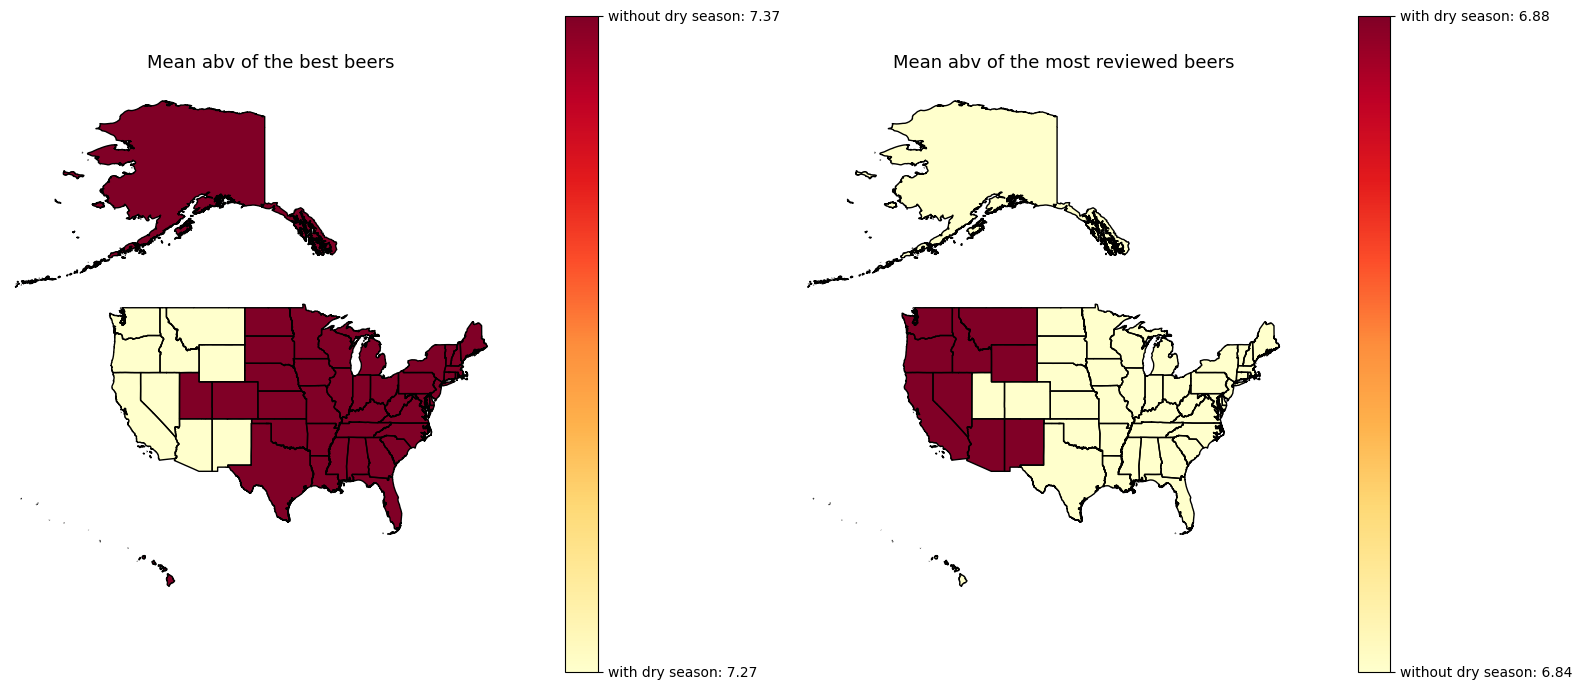

In [44]:
# load the df with the climate classified
climate_classified = pd.read_csv("../data/climate_classified.csv")

# create a df with all the cliate in a column,
# in the second the corresponding climate precipitation a
climate_names_precipitation = pd.DataFrame(
    us_abv_ratings["climate"].unique(), columns=["climate"]
)
climate_names_precipitation["climate_precipitation"] = climate_names_precipitation[
    "climate"
].map(climate_classified.set_index("climate")["seasonal_precipitation"])
# in the third the average abv of the best 3 beers for each climate scheme
climate_names_precipitation["abv_mean"] = climate_names_precipitation[
    "climate_precipitation"
].map(best_beers_precipitation_abv)

# in the fourth the average abv of the most reviewed beers for each climate scheme
climate_names_precipitation["abv_mean_most_reviewd"] = climate_names_precipitation[
    "climate_precipitation"
].map(most_reviewed_precipitation_abv)

# in the fifth the average abv of all the beers for each climate scheme
climate_names_precipitation["abv_mean_overall"] = climate_names_precipitation[
    "climate_precipitation"
].map(mean_abv_weighted)

display(climate_names_precipitation)

plot_climate_multiple_stats(
    climate_names_precipitation,
    columns=["abv_mean", "abv_mean_most_reviewd"],
    titles=[
        "Mean abv of the best beers",
        "Mean abv of the most reviewed beers"
    ],
    column_ticks=["climate_precipitation", "climate_precipitation"],
    cmap_name="YlOrRd",
    separate_colorbars=True,
)

In [45]:
# One-way ANOVA test for the mean abv of each climate precipitation
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_precipitation == zone]["abv"]
        for zone in us_abv_ratings.climate_precipitation.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate precipitation:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate precipitation
res = stats.f_oneway(
    *[
        best_beers_precipitation_dfs[zone]["abv"]
        for zone in best_beers_precipitation_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate precipitation:",
    res[1],
)

# One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation
res = stats.f_oneway(
    *[
        most_reviewed_precipitation_dfs[zone]["abv"]
        for zone in most_reviewed_precipitation_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation:",
    res[1],
)

One-way ANOVA test for the mean abv of each climate precipitation: 5.08100276710351e-08
One-way ANOVA test for the mean abv of best beers of each climate precipitation: 3.001034176773221e-46
One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation: 2.716777093164039e-09


Similarly, we can look at the climate temperature and abv.

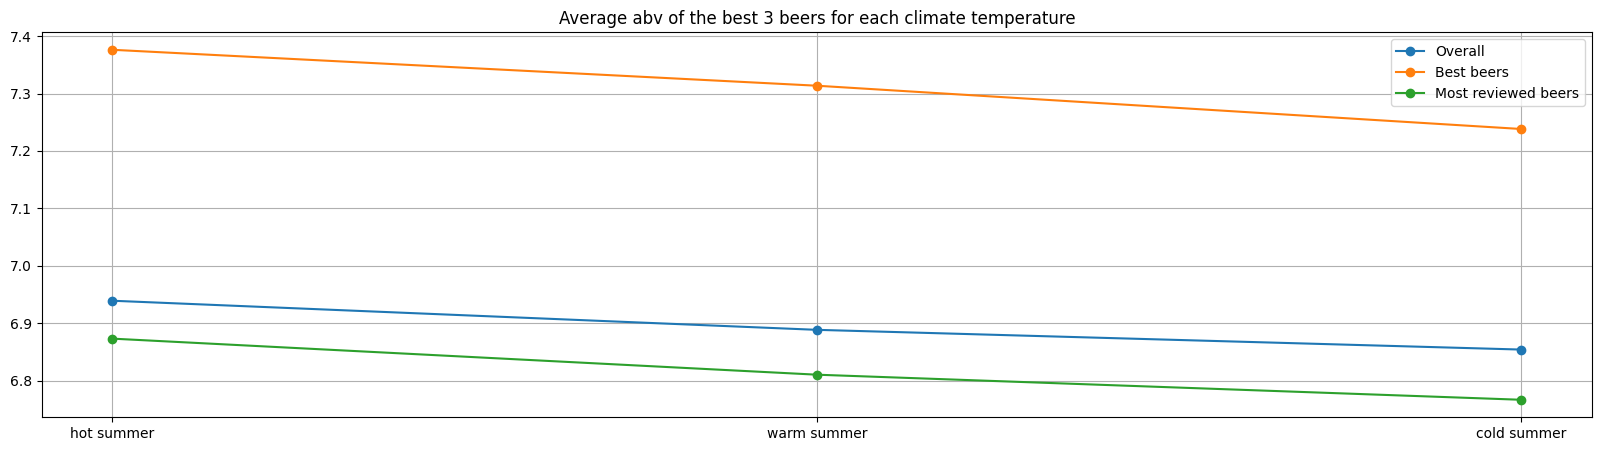

In [46]:
# Now test the climate temperature, as there are multiple values, let's check their abv differences globally first
mean_abv_weighted = {}
best_beers_temperature_dfs = {}
best_beers_temperature_abv = {}
most_reviewed_temperature_dfs = {}
most_reviewed_temperature_abv = {}

for climate_t in us_users_ratings["climate_temperature"].unique():
    climate_temperature_df = us_abv_ratings[
        us_abv_ratings["climate_temperature"] == climate_t
    ]
    mean_abv_weighted[climate_t] = (
        climate_temperature_df["abv"] * climate_temperature_df["overall"]
    ).sum() / climate_temperature_df["overall"].sum()

    us_grouped_beers = climate_temperature_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    # keep only the 3 most reviewed beers
    num_reviews = climate_temperature_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]

    best_beers_temperature_dfs[climate_t] = climate_temperature_df[
        climate_temperature_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)
    best_beers_temperature_abv[climate_t] = best_beers_temperature_dfs[climate_t][
        "abv"
    ].mean()

    most_reviewed_temperature_dfs[climate_t] = climate_temperature_df[
        climate_temperature_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)
    most_reviewed_temperature_abv[climate_t] = most_reviewed_temperature_dfs[climate_t][
        "abv"
    ].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(
    [
        mean_abv_weighted[climate_t]
        for climate_t in us_users_ratings["climate_temperature"].unique()
    ],
    "o-",
    label="Overall",
)
ax.plot(
    [
        best_beers_temperature_abv[climate_t]
        for climate_t in us_users_ratings["climate_temperature"].unique()
    ],
    "o-",
    label="Best beers",
)
ax.plot(
    [
        most_reviewed_temperature_abv[climate_t]
        for climate_t in us_users_ratings["climate_temperature"].unique()
    ],
    "o-",
    label="Most reviewed beers",
)
ax.set_xticks(
    range(len(us_users_ratings["climate_temperature"].unique())),
    us_users_ratings["climate_temperature"].unique(),
)
ax.set_title("Average abv of the best 3 beers for each climate temperature")
ax.grid()
ax.legend()
plt.show()

,climate,climate_heating,abv_mean,abv_mean_most_reviewd,abv_mean_overall
0,Cfa,hot summer,7.376178,6.873136,6.939144
1,Dfa,hot summer,7.376178,6.873136,6.939144
2,Cfb,warm summer,7.313592,6.810338,6.888453
3,Dfb,warm summer,7.313592,6.810338,6.888453
4,Dfc,cold summer,7.238193,6.766647,6.854075
5,Dsc,cold summer,7.238193,6.766647,6.854075
6,Dsb,warm summer,7.313592,6.810338,6.888453
7,Csa,hot summer,7.376178,6.873136,6.939144
8,Csb,warm summer,7.313592,6.810338,6.888453
9,Bsk,cold summer,7.238193,6.766647,6.854075


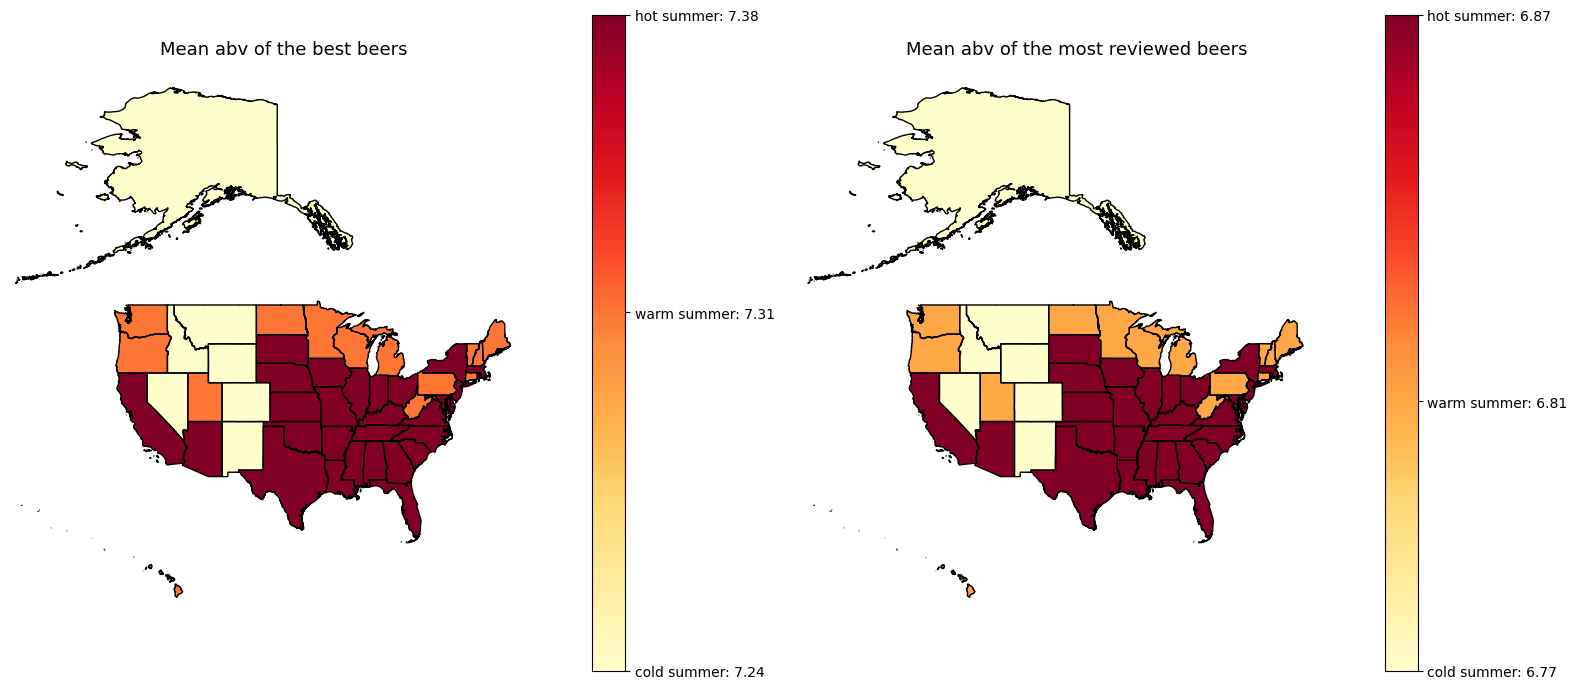

In [47]:
# load the df with the climate classified
climate_classified = pd.read_csv("../data/climate_classified.csv")

# create a df with all the cliate in a column,
# in the second the corresponding climate precipitation a
climate_names_heating = pd.DataFrame(
    us_abv_ratings["climate"].unique(), columns=["climate"]
)
climate_names_heating["climate_heating"] = climate_names_heating["climate"].map(
    climate_classified.set_index("climate")["heat_level"]
)
# in the third the average abv of the best 3 beers for each climate scheme
climate_names_heating["abv_mean"] = climate_names_heating["climate_heating"].map(
    best_beers_temperature_abv
)
climate_names_heating.head(10)

# in the fourth the average abv of the most reviewed beers for each climate scheme
climate_names_heating["abv_mean_most_reviewd"] = climate_names_heating[
    "climate_heating"
].map(most_reviewed_temperature_abv)

# in the fifth the average abv of all the beers for each climate scheme
climate_names_heating["abv_mean_overall"] = climate_names_heating[
    "climate_heating"
].map(mean_abv_weighted)

display(climate_names_heating)

plot_climate_multiple_stats(
    climate_names_heating,
    columns=["abv_mean", "abv_mean_most_reviewd"],
    titles=[
        "Mean abv of the best beers",
        "Mean abv of the most reviewed beers",
    ],
    column_ticks=["climate_heating", "climate_heating"],
    cmap_name="YlOrRd",
    separate_colorbars=True,
)

In [48]:
# One-way ANOVA test for the mean abv of each climate temperature
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_temperature == zone]["abv"]
        for zone in us_abv_ratings.climate_temperature.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate temperature:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate temperature
res = stats.f_oneway(
    *[
        best_beers_temperature_dfs[zone]["abv"]
        for zone in best_beers_temperature_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate temperature:",
    res[1],
)

# One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature
res = stats.f_oneway(
    *[
        most_reviewed_temperature_dfs[zone]["abv"]
        for zone in most_reviewed_temperature_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature:",
    res[1],
)

One-way ANOVA test for the mean abv of each climate temperature: 8.852111294633652e-47
One-way ANOVA test for the mean abv of best beers of each climate temperature: 5.085188781335966e-44
One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature: 4.134520396406788e-56
